In [149]:
import random
import matplotlib.pyplot as plt
import numpy as np
import u3
import time
import bitstring
from functools import reduce
from scipy.signal import butter, lfilter, lfilter_zi, freqz

d = u3.U3()
def setFIO(speed1, speed2):
    d.getFeedback(u3.Timer0Config(TimerMode = 0, Value = int((1-speed1)*65535)))
    d.getFeedback(u3.Timer1Config(TimerMode = 0, Value = int((1-speed2)*65535)))


In [155]:
def getData(frequency, size):
    MAX_REQUESTS = 10
    d.configIO(NumberOfTimersEnabled = 2, FIOAnalog = 4)
    d.configTimerClock(TimerClockBase = 7, TimerClockDivisor = 15)
    trueFrequency = frequency*150
    trueSize = size*8
    direction = 0
    numbers = np.array([])
    while numbers.size < trueSize:
        if direction == 0:
            setFIO(1, 0)
            direction = 1
        elif direction == 1:
            setFIO(0, 1)
            direction = 0
        k = 0
        while (k < trueFrequency and numbers.size < trueSize):
            a1 = d.getAIN(0)
            #a3 = d.getAIN(2)
            #a4 = d.getAIN(3)
            numbers = np.append(numbers, a1)
            #numbers.append(a3)
            #numbers.append(a4)
            k = k+1
            time.sleep(0.01)
        setFIO(0,0)
    
    
    return numbers


def encrypt(key, inputMethod = 1):
    # Read in the input file to be encrypted.
    if inputMethod == 0:
        with open('/Users/veronicabodenstein/Classes/input.txt', 'rb') as inputFile:
            rIn1 = inputFile.read()
        rIn = bytes(rIn1, 'utf-8')
    elif inputMethod == 1:
        rIn1 = input("What do you want to encrypt?")
        rIn = bytes(rIn1, 'utf-8')

    def byteArrayXOR(a1, a2):
        # Calculate the elementwise XOR and return the result as bytes.
        return bytes(map(lambda x, y: x^y, a1,a2))
            
    
    encrypted = byteArrayXOR(rIn, key)
    print(f'The input is: {rIn} \n')
    print(f'The key is: {bytes(key)} \n')
    print(f'The encrypted data is: {encrypted} \n')
    with open('output.txt', 'wb') as outputFile:
        outputFile.write(encrypted)
    decrypted = byteArrayXOR(encrypted,key).decode('UTF-8')
    print(f'The decrypted data is: {decrypted}')


In [110]:
def filterData(cutoff, numbers):

    diff = []
    for i in range(1, len(numbers)):
        value = numbers[i] - numbers[i - 1]
        diff.append(value)

    # Filter requirements.
    order = 6
    fs = 200       # sample rate, Hz

    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)

    zi = lfilter_zi(b, a) * diff[0]

    y, _ = lfilter(b, a, diff, zi=zi)

    #ratio = []
    #nMean = np.mean(numbers)
    #nStd = np.std(numbers)
    #for n in np.arange(len(numbers)/5,1,-1):
    #    result = [np.mean(a) for a in np.array_split(numbers,n)]
    #    data = np.where(np.logical_or(result > nMean+0.2*nStd,result < nMean-0.2*nStd), 1, 0)
    #    ratio.append(sum(data)/len(data))
    return y[1000:], diff

In [152]:
def genRand(data):
    dStd = np.std(data)
    peaks = np.where(data > 0.2*dStd, 1, 0)
    prev = 0
    run = 0
    strings = []
    for i in np.arange(1,len(peaks)):
        if peaks[i] == prev:
            run += 1
        else:
            strings = np.append(strings,run)
            run = 0
        prev = peaks[i]
    bMean = np.mean(strings)
    bStd = np.std(strings)
    bits = np.where(np.logical_or(strings > bMean+0.67*bStd,strings < bMean-0.67*bStd), 1, 0)
    bits = bits[:25]
    bits = ''.join(str(bit) for bit in bits)
    encBytes = int(bits, 2).to_bytes((len(bits) + 7) // 8, byteorder='big')

    return peaks, bits, encBytes

In [169]:
numsOrdered = getData(0.25,500)
time.sleep(5)
numsChaotic = getData(0.20,500)

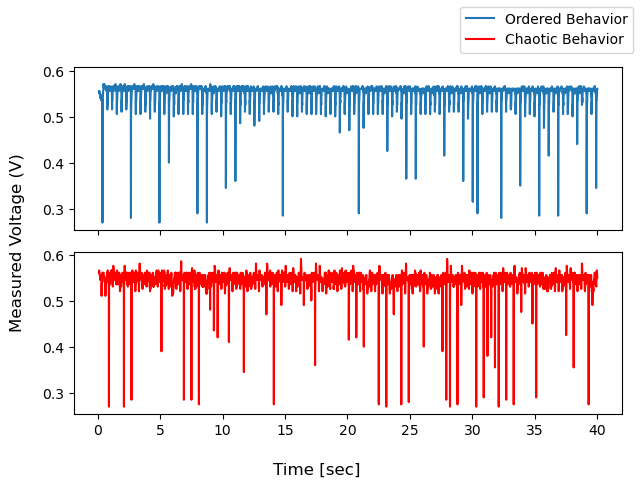

In [170]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
fig.supxlabel('Time [sec]')
fig.supylabel('Measured Voltage (V)')
axs[0].plot(np.arange(1,len(numsOrdered)+1)[10:]/100,numsOrdered[10:], label = 'Ordered Behavior')
axs[1].plot(np.arange(1,len(numsChaotic)+1)[10:]/100,numsChaotic[10:], color = 'red', label = 'Chaotic Behavior')
fig.legend(loc=1)
fig.tight_layout(rect=[0, 0, 1, 0.9])

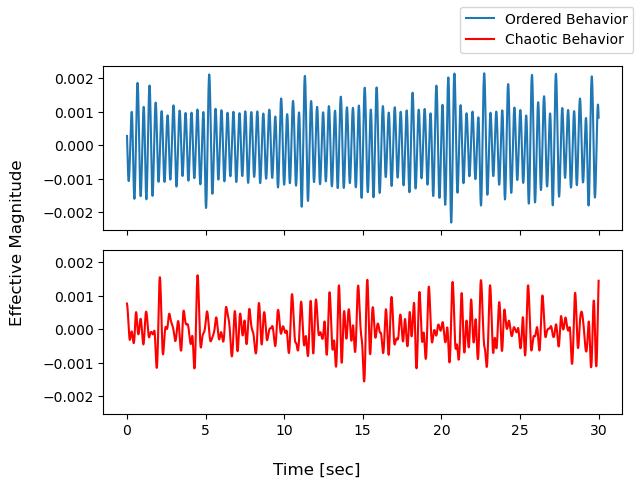

In [171]:
filts1, diffs1 = filterData(5, numsOrdered)
filts2, diffs2 = filterData(5, numsChaotic)

fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
fig.supxlabel('Time [sec]')
fig.supylabel('Effective Magnitude')
axs[0].plot(np.arange(1,len(filts1)+1)/100,filts1, label = 'Ordered Behavior')
axs[1].plot(np.arange(1,len(filts2)+1)/100,filts2, color = 'red', label = 'Chaotic Behavior')
fig.legend(loc=1)
fig.tight_layout(rect=[0, 0, 1, 0.9])

1100110011111100100111011
1110010010100101101010100
b'\x01\x99\xf9;'
b'\x01\xc9KT'


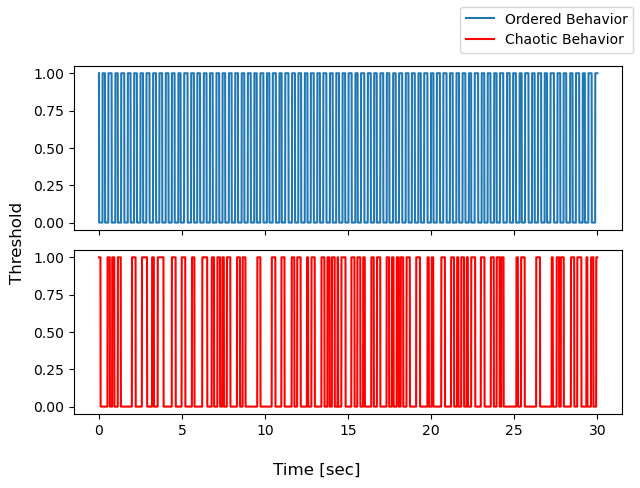

In [172]:
peaks1, bits1, data1 = genRand(filts1)
peaks2, bits2, data2 = genRand(filts2)
fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
fig.supxlabel('Time [sec]')
fig.supylabel('Threshold')
axs[0].plot(np.arange(1,len(peaks1)+1)/100,peaks1, label = 'Ordered Behavior')
axs[1].plot(np.arange(1,len(peaks2)+1)/100,peaks2, color = 'red', label = 'Chaotic Behavior')
fig.legend(loc=1)
fig.tight_layout(rect=[0, 0, 1, 0.9])
print(bits1)
print(bits2)
print(data1)
print(data2)

In [173]:
encrypt(data2)

The input is: b'Test' 

The key is: b'\x01\xc9KT' 

The encrypted data is: b'U\xac8 ' 

The decrypted data is: Test


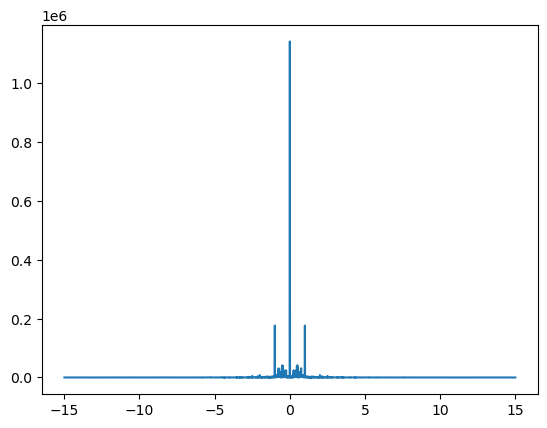

In [174]:

ps = np.abs(np.fft.fft(peaks2))**2

time_step = 1 / 30
freqs = np.fft.fftfreq(peaks2.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])